In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import vice
import sys
sys.path.append("../")
from vice_utils import calculate_z, sample_stars, filter_stars, show_stars, R_to_zone, zone_to_R, show_at_R_z

In [3]:
def load_model(name):
    milkyway = vice.output(name)
    milkyway.stars["abs_z"] = calculate_z(milkyway)
    milkyway.stars["R_origin"] = zone_to_R(np.array(milkyway.stars["zone_origin"]))
    milkyway.stars["R_final"] = zone_to_R(np.array(milkyway.stars["zone_final"]))
    if "[c/o]" not in milkyway.stars.keys():
        milkyway.stars["[c/o]"] = np.array(milkyway.stars["[c/h]"]) / np.array(milkyway.stars["[o/h]"])
    return milkyway

In [4]:
# read in all the models
%cd ~/surp
models = {}
output_dir = "output/"
model_names =  ["cristallo11", "cristallo11_multithreaded", "cristallo11_8stars"]
for name in model_names:
    models[name] = load_model(output_dir + name)

/users/PAS2232/aeyobd/surp


/apps/project/ondemand/app_jupyter/3.0.17/lib64/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [5]:
# sample the stars from each model to show accurate representations
# of the stellar populations
max_zone = 155
stars = {}
for name, model in models.items():
    stars[name] = sample_stars(model.stars.filter("zone_origin", "<", max_zone), num=10_000)

In [14]:
# change to the plot output directories
%cd ~/surp

/users/PAS2232/aeyobd/surp


In [8]:
# not very useful

def annulus_average(output, name, zone_min, zone_max):
    return np.average(np.array([output.zones["zone%i" % i].history[name] 
                                for i in range(zone_min, zone_max)]
                              ),
                      axis=0)

def show_annulus_average(output, x, y, c=None, R_min=7, R_max=9, **kwargs):
    zone_min = R_to_zone(R_min)
    zone_max = R_to_zone(R_max)
    x_values = annulus_average(output, x, zone_min, zone_max)
    y_values = annulus_average(output, y, zone_min, zone_max)
    
    if c is None:
        plt.plot(x_values, y_values, **kwargs)
    else:
        c_values = annulus_average(output, c, zone_min, zone_max)
        plt.scatter(x_values, y_values, c=c_values, **kwargs)
        plt.colorbar()
    plt.xlabel(x)
    plt.ylabel(y)
    
def show_annulus(output, x, y, c=None, R_min=0, R_max=15.4, **kwargs):
    # modified to just show values at present_day
    zone_min = R_to_zone(R_min)
    zone_max = R_to_zone(R_max)
    x_values = [output.zones["zone%i" % i].history[x][-1] for i in range(zone_min, zone_max)]
    y_values = [output.zones["zone%i" % i].history[y][-1] for i in range(zone_min, zone_max)]
    
    if c is None:
        plt.plot(x_values, y_values, **kwargs)
    else:
        c_values = [output.zones["zone%i" % i].history[c][-1] for i in range(zone_min, zone_max)]
        plt.scatter(x_values, y_values, c=c_values, **kwargs)
        plt.colorbar()
    plt.xlabel(x)
    plt.ylabel(y)

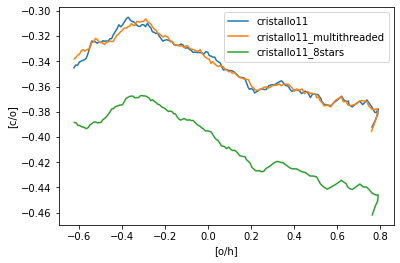

In [16]:
for name, model in models.items():
    show_annulus(model, "[o/h]", "[c/o]", label=name,)
plt.legend()
name = "cooh_gas"
# plt.savefig(name + ".jpeg")
# plt.savefig(name + ".pdf")

In [17]:
def for_each_model(func, sfh="insideout"):
    names = model_names
    
    if sfh=="both":
        for name, model in models.items():
            func(model, name)
    elif sfh=="insideout":
        for name in names:
            func(models[name], name)
    else:
        for name in names:
            n = name + "_" + sfh
            func(models[n], n)

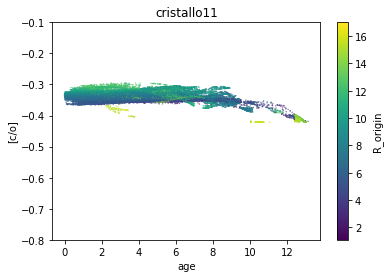

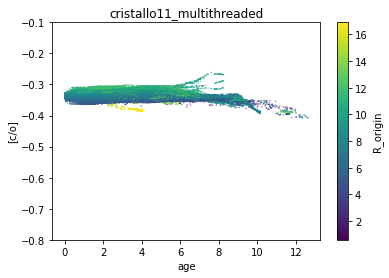

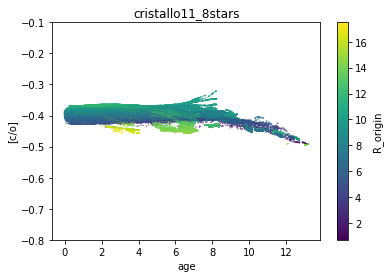

In [19]:
def plot_age_c_o(model, name):
    show_stars(filter_stars(model.stars, 7, 9, 0, 0.5), "age", "[c/o]", c="R_origin", s=0.1)
    plt.title(name)
    plt.ylim(-0.8, -0.1)
    
    name = "co_age_stars_" + name
    # plt.savefig(name + ".jpeg")
    # plt.savefig(name + ".pdf")
    
    plt.show()

    
for_each_model(plot_age_c_o)

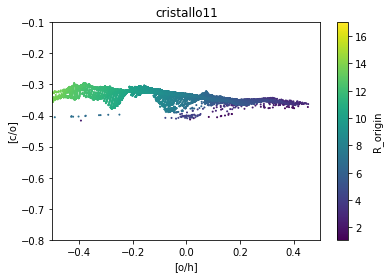

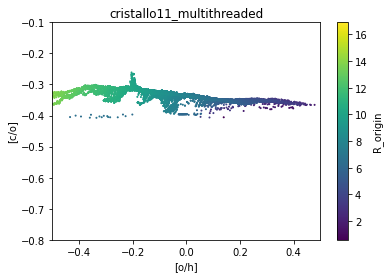

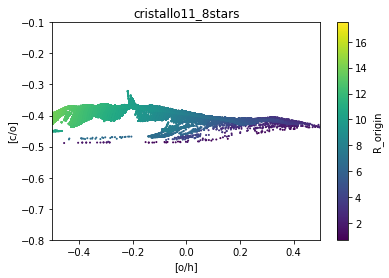

In [20]:
def plot_cooh(model, name):
    show_stars(filter_stars(model.stars, 7, 9, 0, 0.5), "[o/h]", "[c/o]", c="R_origin")
    plt.title(name)
    plt.ylim(-0.8, -0.1)
    plt.xlim(-0.5,0.5)
    
    name = "cooh_stars_" + name
    # plt.savefig(name + ".jpeg")
    # plt.savefig(name + ".pdf")
    
    plt.show()
    
    
for_each_model(plot_cooh)

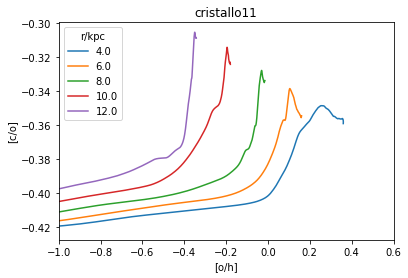

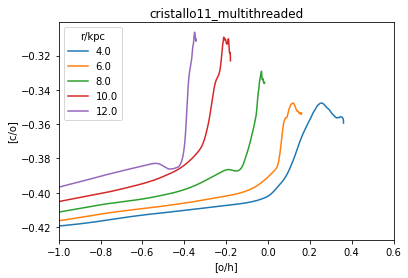

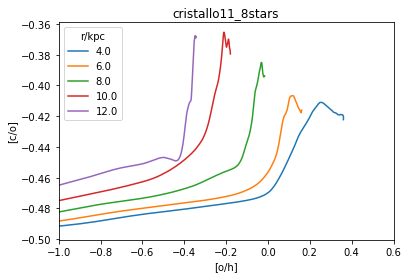

In [21]:
def cooh_age(model, name):
    for i in np.array([4, 6, 8, 10, 12])*10:
        show_annulus_average(model, "[o/h]", "[c/o]", R_min=i/10-0.5, R_max=i/10+0.5, label=i/10)
    plt.legend(title="r/kpc")
    plt.xlim(-1,0.6)
    plt.title(name)
    
    name = "cooh_gas_" + name
    # plt.savefig(name + ".jpeg")
    # plt.savefig(name + ".pdf")
    
    plt.show()

for_each_model(cooh_age)

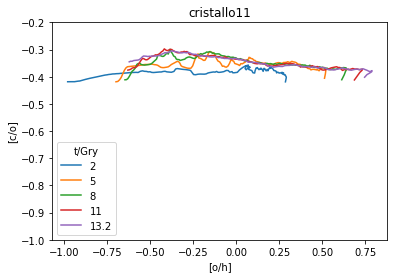

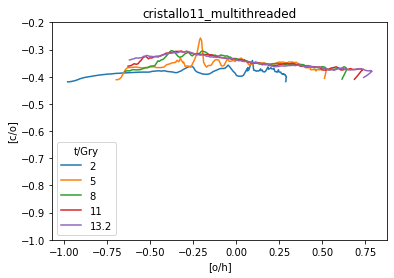

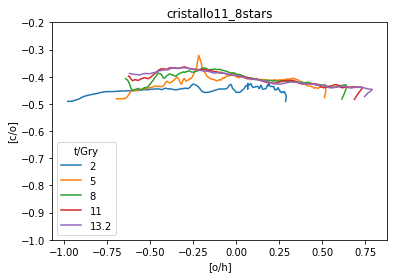

In [22]:
def cooh_R(model, name):
    for t in [2, 5, 8, 11, 13.2]:
        j = int(100*t)

        y = np.zeros(155)
        x = np.zeros(155)
        R = np.arange(0, 15.5, 0.1)

        for i in range(155):
            y[i] = model.zones["zone%i" % i].history["[c/o]"][j]
            x[i] = model.zones["zone%i" % i].history["[o/h]"][j]
        plt.plot(x, y, label=t)

    plt.legend(title="t/Gry")
    #plt.xlim(-1,0.6)
    plt.title(name)
    plt.ylim(-1, -0.2)
    plt.xlabel("[o/h]")
    plt.ylabel("[c/o]")
    
    name = "co_age_gas_" + name
    # plt.savefig(name + ".jpeg")
    # plt.savefig(name + ".pdf")
    
    plt.show()
    
for_each_model(cooh_R)

In [24]:
def means_star_value(stars, value, bin_name, bins):
    N = len(bins) - 1
    means = np.zeros(N)
    sds = np.zeros(N)
    for i in range(N):
        filtered_stars = stars.filter(bin_name, ">=", bins[i]).filter(bin_name, "<", bins[i + 1])
        means[i] = np.mean(filtered_stars[value])
        sds[i] = np.std(filtered_stars[value])
    
    return means, sds

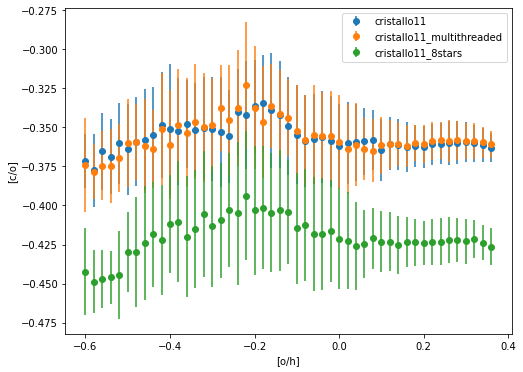

In [25]:
plt.figure(figsize=(8,6))
for name, s in stars.items():
    bins = np.arange(-0.6, 0.4, 0.02)
    y, yerr= means_star_value(s, "[c/o]", "[o/h]", bins)
    plt.errorbar(bins[:-1], y, yerr=yerr, label=name, fmt="o")

plt.legend()
plt.xlabel("[o/h]")
plt.ylabel("[c/o]")

name = "cooh_stars_models"
# plt.savefig(name + ".jpeg")
# plt.savefig(name + ".pdf")